# Homework 04 - Evaluation
The goal of this homework is to determine if a client has subscribed a term deposit or not, using alternative methods to evaluate the model.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

## Dataset
This homework will be using the Bank Marketing dataset.

In [2]:
bm_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"
bm_df = pd.read_csv(bm_url)
bm_df.columns = bm_df.columns.str.lower().str.replace(' ', '_')
bm_df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


## Data preparation
Replace any missing values with `'NA'` (categorical) or `0.0` (numeric).
Split the data into train/val/test (60%/20%/20%).

In [3]:
categorical_cols = list(bm_df.dtypes[bm_df.dtypes == 'object'].index)
numeric_cols = [col for col in list(bm_df.dtypes.index) if col not in categorical_cols and col != 'converted']
(categorical_cols, numeric_cols)

(['lead_source', 'industry', 'employment_status', 'location'],
 ['number_of_courses_viewed',
  'annual_income',
  'interaction_count',
  'lead_score'])

In [4]:
bm_df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [5]:
bm_df[categorical_cols] = bm_df[categorical_cols].fillna('NA')
bm_df[numeric_cols] = bm_df[numeric_cols].fillna(0.0)

In [6]:
bm_df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [7]:
full_train_df, test_df = train_test_split(bm_df, test_size=0.2, random_state=1)
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=1)
(len(train_df), len(val_df), len(test_df))

(876, 293, 293)

## Question 1
Which numerical variable has the highest AUC? `lead_score`, `number_of_courses_viewed`, `interaction_count`, or `annual_income`?

In [8]:
feature_importance = []

for num_col in train_df.dtypes[train_df.dtypes != 'object'].index:
    ras = roc_auc_score(train_df.converted, train_df[num_col])
    if ras < 0.5:
        ras = roc_auc_score(train_df.converted, -train_df[num_col])
    feature_importance.append(
        (num_col, ras))

pd.DataFrame(feature_importance, columns=['feature', 'roc_auc_score']).sort_values(by='roc_auc_score', ascending=False)

,feature,roc_auc_score
4,converted,1.000000
0,number_of_courses_viewed,0.763568
2,interaction_count,0.738270
3,lead_score,0.614499
1,annual_income,0.551958


## Question 2
What is the AUC of the model on the validation dataset?

In [9]:
def train(tr_df, v_df, C=1.0):
    train_dict = tr_df.drop('converted', axis=1).to_dict(orient='records')
    train_y = tr_df.converted.values

    val_dict = v_df.drop('converted', axis=1).to_dict(orient='records')
    val_y = v_df.converted.values
    
    dv = DictVectorizer(sparse=False)
    train_X = dv.fit_transform(train_dict)
    val_X = dv.transform(val_dict)

    model = LogisticRegression(
        solver='liblinear',
        C=C,
        max_iter=1000)
    model.fit(train_X, train_y)

    pred_y = model.predict_proba(val_X)[:, 1]

    return val_y, pred_y

In [10]:
def ras(tr_df, v_df, C=1.0):
    val_y, pred_y = train(tr_df, v_df, C)
    return roc_auc_score(val_y, pred_y)

In [11]:
round(ras(train_df, val_df), 3)

0.817

## Question 3
At which threshold precision and recall curves intersect?

In [12]:
def confusion_table(v_y, p_y, t):
    actual_pos = (v_y == 1)
    actual_neg = (v_y == 0)
    predict_pos = (p_y >= t)
    predict_neg = (p_y < t)

    true_pos = (predict_pos & actual_pos).sum()
    true_neg = (predict_neg & actual_neg).sum()
    false_pos = (predict_pos & actual_neg).sum()
    false_neg = (predict_neg & actual_pos).sum()

    return true_neg, false_pos, false_neg, true_pos

In [13]:
def precision_and_recall(v_y, p_y, t):
    tn, fp, fn, tp = confusion_table(v_y, p_y, t)
    if (tp + fp) == 0:
        print("tp + fp", t, tp, fp)
    if (tp + fn) == 0:
        print("tp + fn", t, tp, fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

In [14]:
def calc_evals(tr_df, v_df):
    val_y, pred_y = train(tr_df, v_df)

    prec_rec = []
    
    for threshold in [i / 100 for i in range(101)]:
        prec, rec = precision_and_recall(val_y, pred_y, threshold)
        f1 = 2 * ((prec * rec) / ( prec + rec))
        prec_rec.append((threshold, prec, rec, f1, abs(prec - rec)))

    prec_rec_df = pd.DataFrame(prec_rec, columns=['t', 'p', 'r', 'f1', 'prdiff'])

    return prec_rec_df

tp + fp 0.98 0 0
tp + fp 0.99 0 0
tp + fp 1.0 0 0


/tmp/ipykernel_82719/4294927462.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


t         0.640000
p         0.779070
r         0.783626
f1        0.781341
prdiff    0.004556
Name: 64, dtype: float64

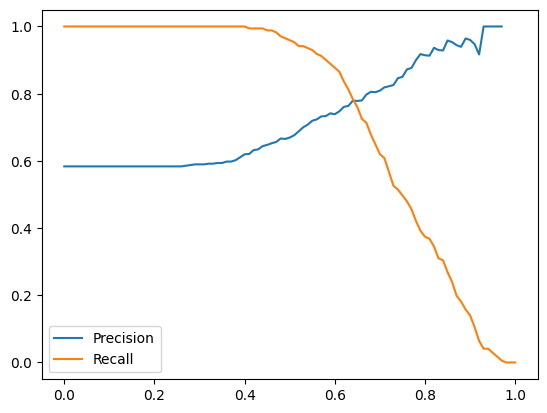

In [15]:
evals_df = calc_evals(train_df, val_df)

plt.plot(evals_df.t, evals_df.p, label='Precision')
plt.plot(evals_df.t, evals_df.r, label='Recall')
plt.legend()

evals_df.loc[evals_df['prdiff'].idxmin()]

## Question 4
At which threshold is F1 maximal?

t         0.570000
p         0.732394
r         0.912281
f1        0.812500
prdiff    0.179886
Name: 57, dtype: float64

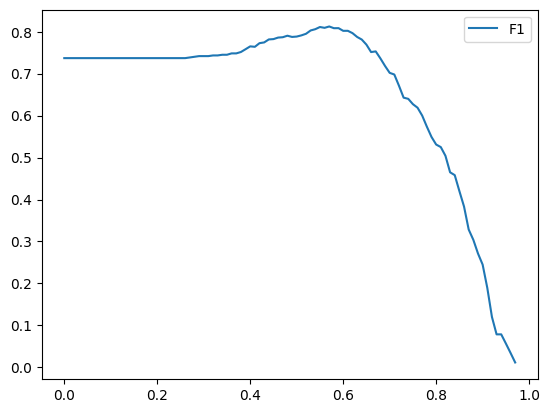

In [16]:
plt.plot(evals_df.t, evals_df.f1, label='F1')
plt.legend()

evals_df.loc[evals_df['f1'].idxmax()]

## Question 5
How large is the standard deviation of the scores across different folds?

In [17]:
def kfold_eval(train_df, C=1.0):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(train_df):
        scores.append(ras(train_df.iloc[train_idx], train_df.iloc[val_idx], C))

    return scores

In [18]:
print(np.std(kfold_eval(full_train_df)))

0.03580711942905165


## Question 6
Which `C` leads to the best mean score?

In [19]:
def kfold_c_eval(train_df):
    results = []

    for C in [0.000001, 0.001, 1]:
        scores = kfold_eval(train_df, C)
        results.append(
            (
                C,
                round(np.std(scores), 3),
                round(np.mean(scores), 3)
            )
        )
    
    return pd.DataFrame(results, columns=['C', 'std', 'mean'])

In [20]:
kfold_c_eval(full_train_df)

,C,std,mean
0,0.000001,0.024,0.560
1,0.001000,0.029,0.867
2,1.000000,0.036,0.822
